# Analyzing the Impact of Ascites and D-Penicillamine on Mortality in Primary Biliary Cirrhosis Patients: A Statistical Inference Study
#### Authors: Hrishi Logani, Rithika Nair, Yuexiang Ni, Yuxi Zhang (Group 43)

## Introduction

Primary biliary cirrhosis (PBC) is a chronic condition characterized by gradual damage and deterioration of the liver's bile ducts, leading to substantial liver-related health challenges. PBC stands as a prominent contributor to liver-related illnesses and fatalities. The prognosis of PBC is influenced by multiple factors critical to effective treatment (Prince et al., 2002). Notably, advanced PBC often manifests the complication of ascites, characterized by an accumulation of fluid in the abdominal cavity (Purohit, 2015). This project endeavors to examine how ascites impacts the prognosis of patients receiving D-penicillamine. It's worth noting that the effectiveness of D-penicillamine remains uncertain (Purohit, 2015). We chose to analyze this to improve patient treatment insights. Thus, we are asking the following question:

#### For Primary Biliary Cirrhosis patients administered with D-Penicillamine, does the presence of Ascites determine their mortality?

To investigate this, we shall analyze the difference in mortality rate based on the following categorical variables and the scale parameter will be a standard error of proportions.

* Type of treatment (D-penicillamine or Placebo)
* Presence of Ascites

The analysis will focus on comparing proportions, as both "Drug" type and "Ascites" presence have only two discrete outcomes. Standard error will be used to quantify the statistic's variation from the population proportion. This project seeks to provide insights into the impact of "Ascites" on the prognosis of PBC patients treated with "D-penicillamine," using a comprehensive dataset for a thorough investigation.

The dataset used is the __[Cirrhosis Patient Survival Prediction](https://archive.ics.uci.edu/dataset/878/cirrhosis+patient+survival+prediction+dataset-1)__ dataset from the UCI Machine Learning Repository, containing information on 418 PBC patients. Each patient's data includes unique identifiers ("ID"), days between registration ("N_Days"), patient status ("Status"), drug type ("Drug"), age ("Age"), sex ("Sex"), and various clinical parameters.

## Methods & Results

### Loading Necessary Libraries

In [3]:
install.packages("infer")
install.packages("gridExtra")

library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




### Downloading Dataset from the Web

* Downloading the dataset that is stored in a public repository.

In [59]:
# URL containing the dataset
url <- "https://raw.githubusercontent.com/Rithika-Nair/STAT-201-Final_Project/main/cirrhosis.csv"

# Download cirrhosis.csv from the url
download.file(url, "cirrhosis.csv")

# Store the dataset into variable
cirr_data <- read.csv("cirrhosis.csv")

# Display the first few rows of the dataset
head(cirr_data)

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>
1,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261,2.60,156,1718.0,137.95,172,190,12.2,4
2,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302,4.14,54,7394.8,113.52,88,221,10.6,3
3,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176,3.48,210,516.0,96.10,55,151,12.0,4
4,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244,2.54,64,6121.8,60.63,92,183,10.3,4
5,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279,3.53,143,671.0,113.15,72,136,10.9,3
6,6,2503,D,Placebo,24201,F,N,Y,N,N,0.8,248,3.98,50,944.0,93.00,63,NA,11.0,3


### Data Cleaning and Preprocessing

* Selecting columns relevant to our analysis: `Status`, `Drug`, `Ascites`.

In [60]:
cirrhosis <- cirr_data %>%
        select(Status, Drug, Ascites)

head(cirrhosis)
nrow(cirrhosis)

,Status,Drug,Ascites
,<chr>,<chr>,<chr>
1,D,D-penicillamine,Y
2,C,D-penicillamine,N
3,D,D-penicillamine,N
4,D,D-penicillamine,N
5,CL,Placebo,N
6,D,Placebo,N


[1] 418

* Checking for missing values in each of the columns and removing the rows that contain missing values.

In [61]:
# Printing the number of missing values in each column
print(sum(is.na(cirrhosis$Status)))
print(sum(is.na(cirrhosis$Drug)))
print(sum(is.na(cirrhosis$Ascites)))

[1] 0
[1] 106
[1] 106


In [62]:
# Filtering out the rows containing NA values in either Drug or Ascites columns
cirrhosis_filtered <- cirrhosis %>%
        filter(!is.na(Drug)) %>%
        filter(!is.na(Ascites)) %>%
        filter(Status %in% c("CL", "D"))

head(cirrhosis_filtered)
nrow(cirrhosis_filtered)

,Status,Drug,Ascites
,<chr>,<chr>,<chr>
1,D,D-penicillamine,Y
2,D,D-penicillamine,N
3,D,D-penicillamine,N
4,CL,Placebo,N
5,D,Placebo,N
6,D,Placebo,N


[1] 144

### Exploratory data analysis


* We shall conduct our analysis by grouping the patients into 2 different groups.
    * Group 1: Patients administered with D-penicillamine and have Ascites
    * Group 2: Patients administered with D-penicillamine but don't have Ascites.




In [63]:
# filtering dataset to include only those administered with D-penicillamine
patients_dp <- cirrhosis_filtered |>
               filter(Drug == "D-penicillamine")
head(patients_dp)

,Status,Drug,Ascites
,<chr>,<chr>,<chr>
1,D,D-penicillamine,Y
2,D,D-penicillamine,N
3,D,D-penicillamine,N
4,D,D-penicillamine,N
5,D,D-penicillamine,N
6,D,D-penicillamine,N


Now, we shall perform bootstraping on the variable presence of Ascites.

In [64]:
# set seed to ensure reproducability
set.seed(69)

bootstrap_ascites_present <- patients_dp |>
                             specify(response = Ascites, success = "Y") |>
                             generate(type = "bootstrap", reps = 1000) |>
                             calculate(stat="prop")
ascites_present_ci <- bootstrap_ascites_present |>
                      get_ci(level = 0.95, type = "percentile")

bootstrap_ascites_absent <- patients_dp |>
                            specify(response = Ascites,  success = "N") |>
                            generate(type = "bootstrap", reps = 1000) |>
                            calculate(stat="prop")

ascites_absent_ci <- bootstrap_ascites_absent |>
                      get_ci(level = 0.95, type = "percentile")

ascites_present_ci
ascites_absent_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.09333333,0.2666667


lower_ci,upper_ci
<dbl>,<dbl>
0.7466667,0.9066667


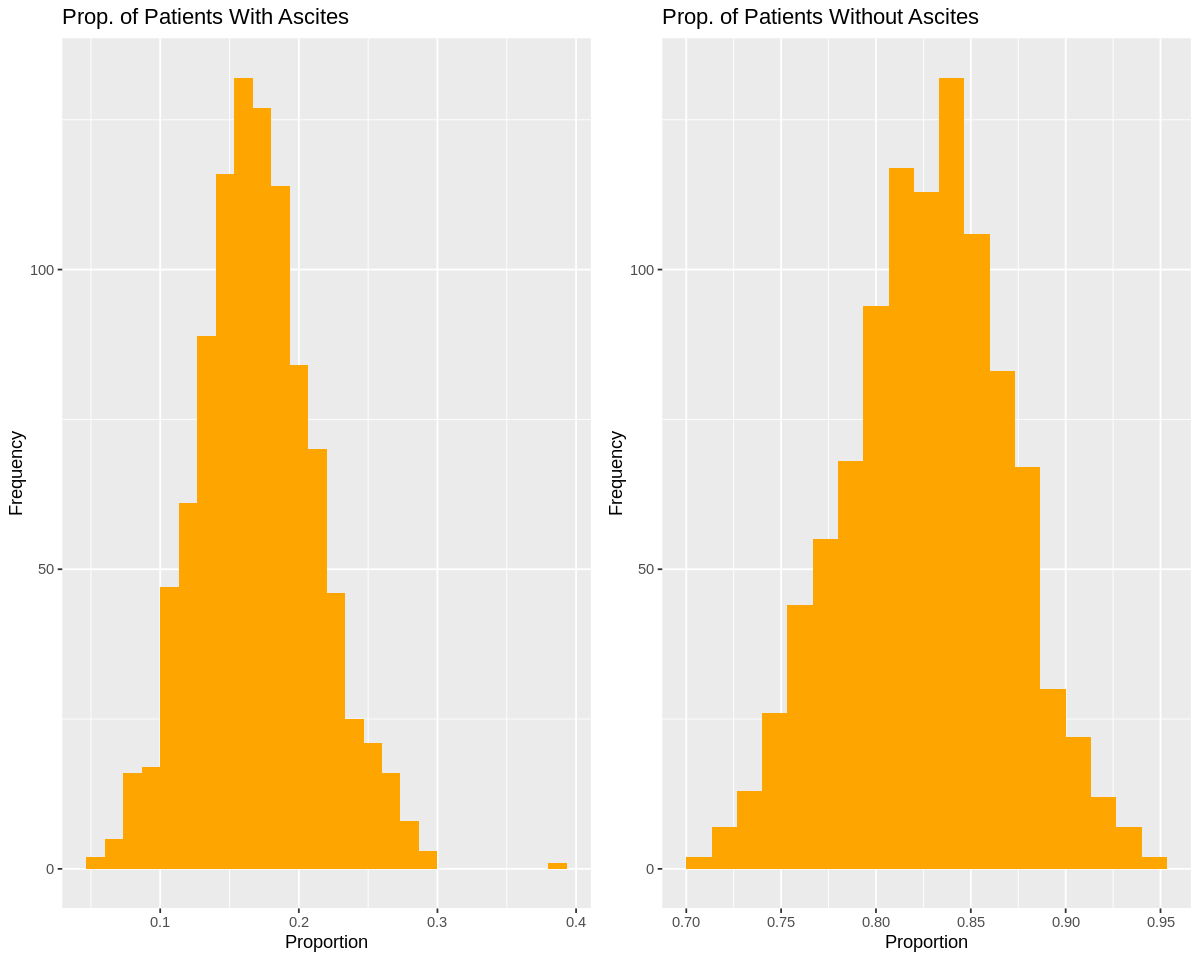

In [65]:
# bootstrap sampling distribution for patients that  have ascites
ascites_present_plot <- bootstrap_ascites_present |>
  ggplot(aes(x = stat)) +
  geom_histogram(bins = 26, fill = "orange") +
  ggtitle("Prop. of Patients With Ascites") +
  labs(x = "Proportion", y = "Frequency")

# bootstrap sampling distribution for patients that don't have ascites
ascites_absent_plot <- bootstrap_ascites_absent |>
                       ggplot(aes(x = stat)) +
                       geom_histogram(bins = 19, fill = "orange") +
                       ggtitle("Prop. of Patients Without Ascites") +
                       labs(x = "Proportion", y = "Frequency")

# Arrange the plots side by side
grid.arrange(ascites_present_plot, ascites_absent_plot, ncol = 2)

* As we will be looking at the proportion of patients who died in Group 1 and Group 2, we will begin by first visualizing proportions from the raw data of patients administered with D-penicillamine.

Now, let's delve into the examination of the mortality rates within each group to understand the proportion of individuals who have unfortunately passed away.

In [66]:
# Counting the patients who have died in Group 1 and Group 2
patients_dp_died <- patients_dp |>
                    group_by(Ascites) |>
                    filter(Status == "D") |>
                    summarize(count = n())

# patients_dp_died

# Calculating the proportion of patients in Group 1 and Group 2
prop_dp_died <- patients_dp_died |>
                mutate(prop = count/sum(count)) |>
                select(Ascites, prop)

prop_dp_died

Ascites,prop
<chr>,<dbl>
N,0.8
Y,0.2


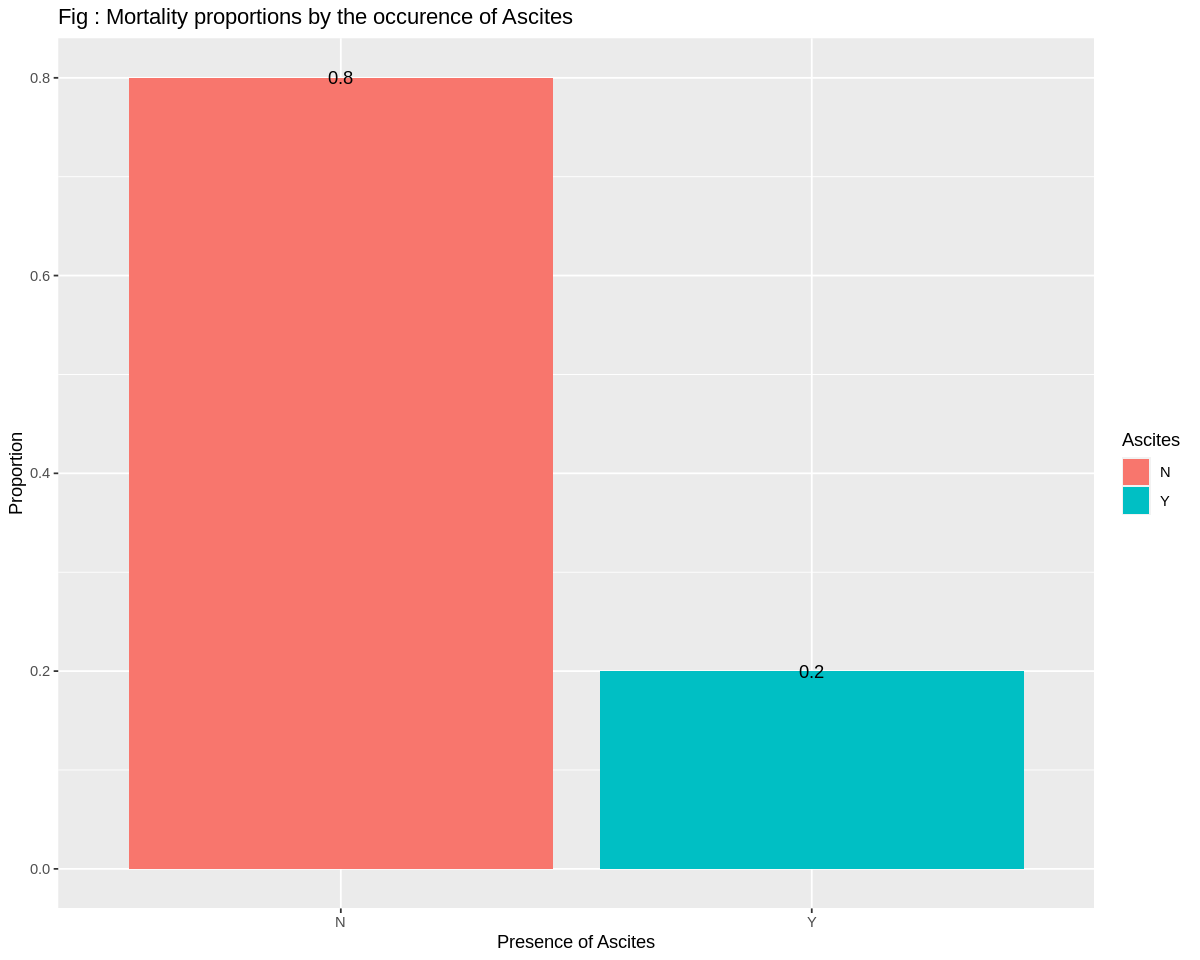

In [79]:
# set the size of the plot (optional)
options(repr.plot.width = 10, repr.plot.height = 8)

# Plot a histogram to visualize the proportions
raw_data_prop_plot <- prop_dp_died |>
                      ggplot(aes(x = Ascites, y = prop, fill = Ascites)) +
                      geom_col() +
                      labs(title = "Fig : Mortality proportions by the occurence of Ascites", x = "Presence of Ascites", y = "Proportion") +
                      geom_text(aes(label = prop))

raw_data_prop_plot

The above figure  indicates a noteworthy contrast in the mortality rates of patients treated with D-penicillamine, distinguishing between those with and without Ascites. The observed disparity in outcomes suggests a significant difference.

### Hypothesis Testing

The estimates produced in the previous section are not sufficient as there is no mention of the statistical significance of the evidence. Therefore, we will need to perform hypothesis testing to determine the reliability of our conclusion. We plan to support our data by testing the following hypothesis:

*   $ H_0 : p_1 - p_2 = 0$
*   $ H_1 : p_1 - p_2 \neq 0$



Here, $p_1$ denotes the proportion of patients administered with D-penicillamine and have Ascites who died, while $p_2$ represents the proportion of patients administered with D-penicillamine and do not have ascites but still died. The objective is to rigorously assess the statistical evidence supporting our conclusions.
The null hypothesis states that the difference in mortality rates between patients administered with D-penicillamine and have Ascites ($p_1$) and those administered with D-penicillamine without ascites ($p_2$) who died is zero whereas the alternative hypothesis states that there is a difference between mortality rates between the two groups.

We have chosen a significance level of $α=0.05$ for our hypothesis testing, striking a balance between the probabilities of type 1 and type 2 errors. Opting for a lower significance level would elevate the risk of committing a type 2 error, which, in this context, is more consequential than a type 1 error. A type 2 error would imply the erroneous conclusion that there is no difference in mortality rates when, in fact, there is. Conversely, increasing the significance level would necessitate stronger evidence to reach a statistically significant conclusion. Hence, our selected significance level aligns with the objective of minimizing both types of errors while maintaining a practical balance.


### Creating the null model
*   Now, we shall calculate the summary statistic and make a null distribution using the infer package.


In [69]:
# set seed to ensure that data is reproducible
set.seed(69)

# create the null distribution
null_distribution <- patients_dp |>
                     specify(formula = Status ~ Ascites, success = "D") |>
                     hypothesize(null="independence") |>
                     generate(reps = 1000, type = "permute") |>
                     calculate(stat = "diff in props", order = c("Y", "N"))

head(null_distribution)


replicate,stat
<int>,<dbl>
1,-0.02481390
2,0.06823821
3,0.16129032
4,0.06823821
5,-0.11786600
6,0.16129032


Table <No> : 1000 samples taken from the Null Model using the infer package

### Calculating test statistic


*  Now, we shall calculate the observed difference in mortality rates using infer package.



In [70]:
obs_diff_prop <- patients_dp |>
                 specify(Status ~ Ascites, success = "D") |>
                 calculate(stat = "diff in props", order = c("Y", "N"))
obs_diff_prop

stat
<dbl>
0.1612903


Table : Observed Difference in Proportions

### Visualizing the p-value


*   The final step is to visualize the p-value on the null distribution
*   This means that if the null hypothesis holds true, how surprised would we be to see a difference in mortality rates of 16.13%?
*   We accomplish this by first visualizing the null distribution using the  function ```visualize()``` function of infer package, and then we shall use ```shade_p_value``` function and set ```obs_stat``` to ```obs_diff_prop``` and we will set the ```direction = "right"``` because our alternative hypothesis is "more extreme" than the hypothesized world.



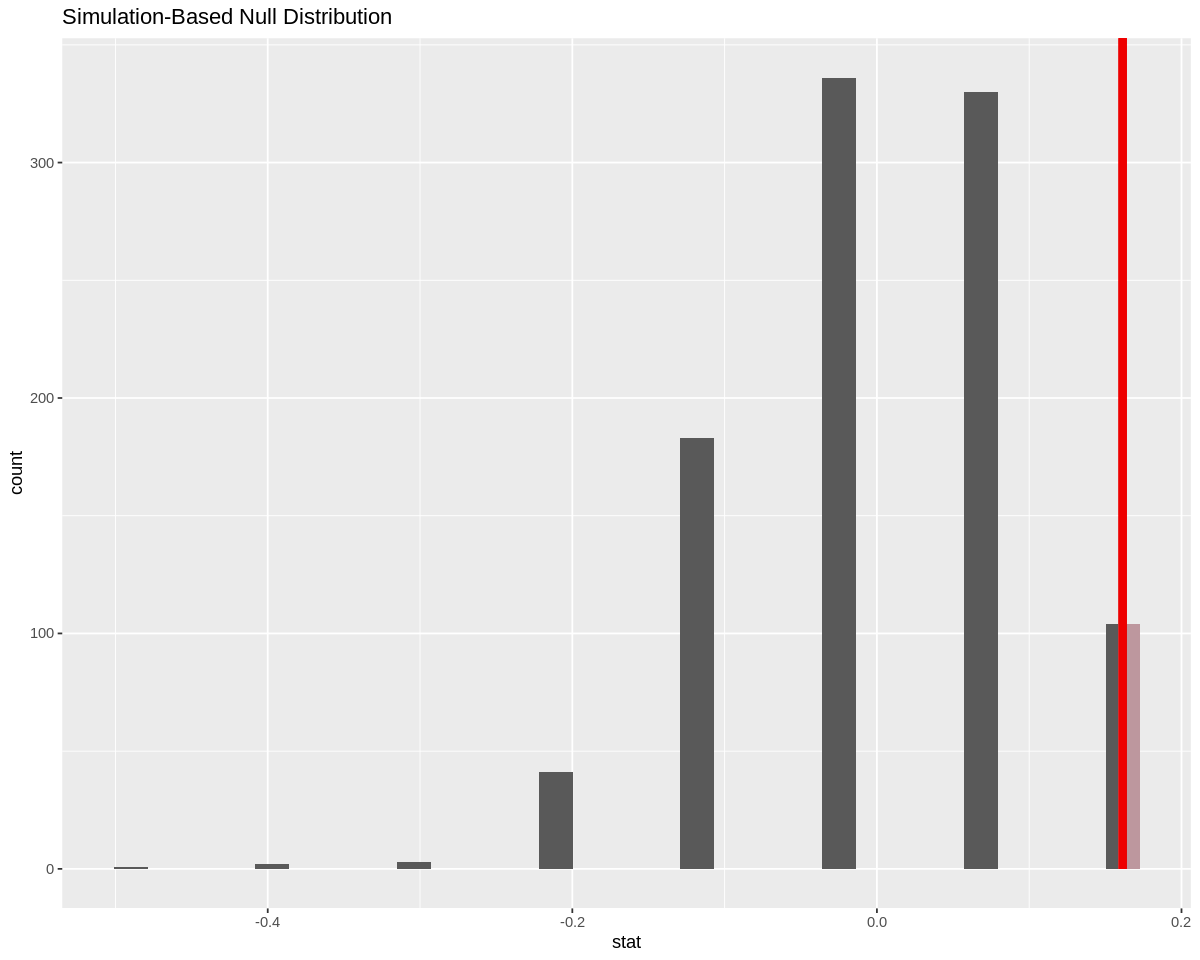

In [78]:
# set the size of the plot
options(repr.plot.width = 10, repr.plot.height = 8)

# visualizing the null distribution
visualise(null_distribution) +
         shade_p_value(obs_stat = obs_diff_prop, direction = "right")



*   After visualizing the p-value on the null distribution, we can tell that there are chances that we will see a difference in the survival rates of 16.13% in a hypothesized worlf of no difference in the mortality rates between the two groups.
*   Therefore, we would fail to reject the null hypothesis, in statistical terminology - "Do not reject $H_0$".



### Computing the p-value


*   We shall compute the p-value using ```get_p_value``` function with ```obs_stat = obs_diff_prop``` and ```direction = "right"```.  



In [ ]:
p_val <- null_distribution |>
         get_p_value(obs_stat = obs_diff_prop, direction = "right")



*   This information indicates that there is a 12.9% probability of observing a mortality rate difference as substantial as 16.13% between individuals treated with D-penicillamine, distinguishing between those with and without ascites, solely due to random sampling fluctuations in a null distribution.
*   Since the p-value is larger than our pre-specified significance level of 0.05, we fail to reject the null hypothesis.



### Bootstrap method for difference in proportions

*   We shall now use boostrapping methods to test our hypothesis.


In [ ]:
# set the seed to ensure that data is reproducible
set.seed(69)

# generating the bootstrapping distribution with reps = 1000
bootstrap_distribution <- patients_dp |>
                          specify(formula = Status ~ Ascites, success = "D") |>
                          generate(reps = 1000, type = "bootstrap") |>
                          calculate(stat="diff in props", order = c("Y", "N"))
head(bootstrap_distribution)

replicate,stat
<int>,<dbl>
1,0.1774194
2,0.1940299
3,0.1896552
4,0.1093750
5,0.1639344
6,0.1641791


In [ ]:
# generate the upper and lower confidence intervals with 95% confidence level
percentile_ci <- bootstrap_distribution |>
                 get_ci(level = 0.95, type = "percentile")
percentile_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.078125,0.2586769


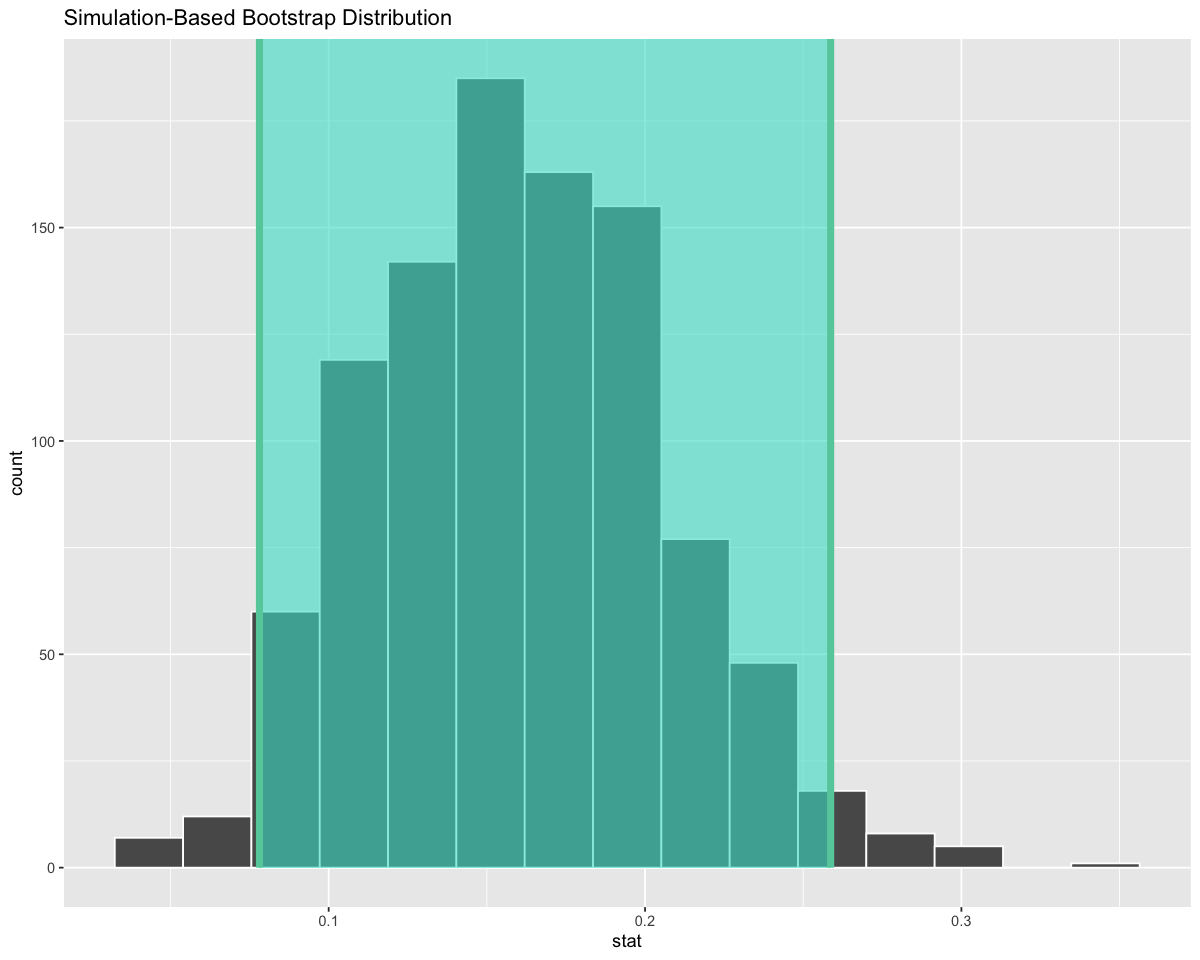

In [ ]:
# set the size of the plot
options(repr.plot.width = 10, repr.plot.height = 8)

# visualizing the 95% confidence interval on bootstrap disribution
visualize(bootstrap_distribution) +
  shade_confidence_interval(endpoints = percentile_ci)





*   From the above figure, we are 95% confident that the true difference in the population proportions $p_1 - p_2$ lies between 7.81% and 25.86%
*   We can also deduce that our calculated p-value of 0.129 falls within the 95% confidence interval (0.0781, 0.2586), indicating that the disparity between $p_1$ and $p_2$ lacks statistical significance.


### Standard Error Method


*   Since the bootstrap distribution is roughly normally distributed, we can also compare it with the confidence interval generate from the standard error method.
*   Here, we would use the ```get_ci``` function and set ```level = 0.95```,
    ``` type = se``` and ```point_estimate = obs_diff_prop```.



In [ ]:
# generating 95% confidence level
se_ci <- bootstrap_distribution |>
         get_ci(level = 0.95, type = "se", point_estimate = obs_diff_prop)
se_ci

lower_ci,upper_ci
<dbl>,<dbl>
0.07090481,0.2516758


### Visualize using Standard Error Method


*   Now, we'll visualize the bootstrap distribution again using the confidence interval we calculated using the standard error method.


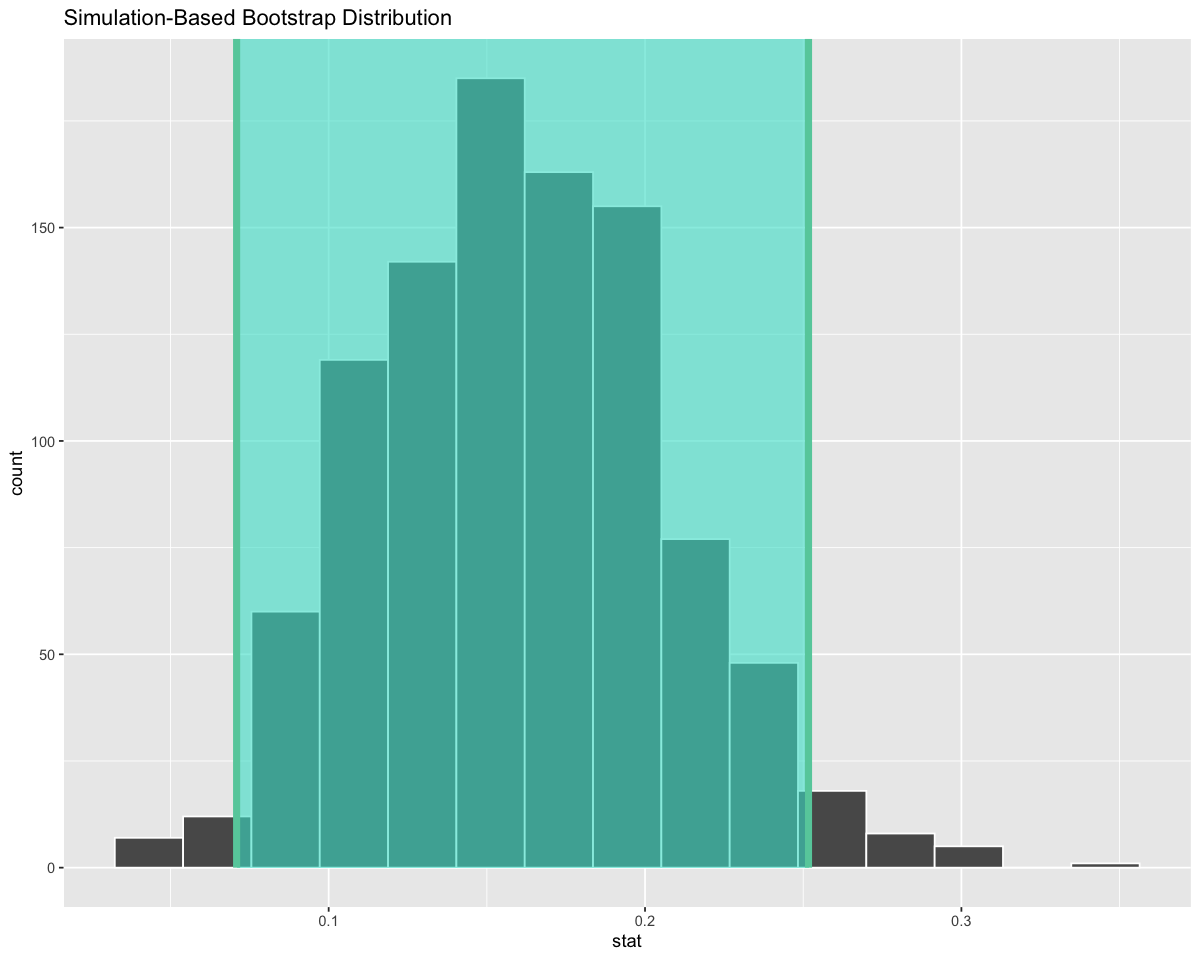

In [ ]:
# set the size of the plot
options(repr.plot.width = 10, repr.plot.height = 8)

# visualizing the 95% confidence interval on bootstrap disribution
visualize(bootstrap_distribution) +
  shade_confidence_interval(endpoints = se_ci)



*   Again, here we notice that the p-value of 0.129 is included in the confidence interval which shows that difference between $p_1$ and $p_2$ is not statistically significant.



### Two Sample Z-test: Comparing the proportions of two independent populations using asymptotics

Here, we'll consider the following case:

*   $H_0: p_1 - p_2 = 0$ vs $H_1: p_1 - p_2 \neq 0$

to test $H_0$, we will use the following test statistic:
$$Z = \frac {\hat{p_1} - \hat{p_2}}{\sqrt{\hat{p}(1-\hat{p})(\frac{1}{n_1} + \frac{1}{n_2})}}$$

Pooled proportion is given by,
$$\hat{p} = \frac{n_1\hat{p_1}  + n_2\hat{p_2}}{n_1 + n_2}$$

In [ ]:
# create a variable for patients with Ascites
sample_1 <- patients_dp |>
            filter(Ascites == "Y")

# create a variable for patients without Ascites
sample_2 <- patients_dp |>
            filter(Ascites == "N")

# Using R's prop.test() function to calculate the p-value given by Z-test
# also using broom:tidy() to make the result presentable

stats <- tidy(prop.test(x = c(sum(sample_1$Status == "D"),
                              sum(sample_2$Status == "D")),
                              n = c(nrow(sample_1), nrow(sample_2)),
                              alternative = "two.sided",
                              correct = F))
stats

Warning message in prop.test(x = c(sum(sample_1$Status == "D"), sum(sample_2$Status == :
“Chi-squared approximation may be incorrect”


estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.8387097,2.419355,0.1198443,1,0.0697395,0.2528411,2-sample test for equality of proportions without continuity correction,two.sided




*   In the above code snippet, we calculated the ```p-value```, ```conf.low``` and ```conf.high``` using prop.test() function in R. We used a 2-sample Z-test for comparing the proportions.
*   We found the p-value of 0.1198, which is higher than our significance level of 0.05.
*  Due to this, we shall not reject the null hypothesis at a 5% significance level.



## References


Prince, M., Chetwynd, A., Newman, W., Metcalf, J. V., &amp; James, O. F. W. (2002). Survival and symptom progression in a geographically based cohort of patients with primary biliary cirrhosis: Follow-up for up to 28 years. Gastroenterology, 123(4), 1044–1051. __https://doi.org/10.1053/gast.2002.36027__

Purohit, T. (2015). Primary biliary cirrhosis: Pathophysiology, clinical presentation and therapy. World Journal of Hepatology, 7(7), 926. __https://doi.org/10.4254/wjh.v7.i7.926__

Dickson,E., Grambsch,P., Fleming,T., Fisher,L., and Langworthy,A.. (2023). Cirrhosis Patient Survival Prediction. UCI Machine Learning Repository. __https://doi.org/10.24432/C5R02G.__